# Water vapor retrieval using principal components

This notebook provides an example of a passive microwave water vapor (WV) retrieval using ARTS.

Authors: Simon Pfreundschuh and David Duncan, Chalmers University

# Set up ARTS/Python environment


In [1]:
%env ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simonpf/build/arts_fast/
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity = 0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")

env: ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simonpf/build/arts_fast/
Loading ARTS API from: /home/simonpf/build/arts_fast/src/libarts_api.so


In [2]:
# define absorbing species and sensor (here using metmm library, used again below)
ws.Copy(ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])
ws.ReadXML( ws.abs_lines, "instruments/metmm/abs_lines_metmm.xml.gz")
ws.abs_lines_per_speciesCreateFromLines()

# General Settings

In [3]:
ws.stokes_dim = 1
ws.jacobian_quantities = []
ws.iy_unit = "PlanckBT"
ws.cloudboxOff()

# Atmosphere set up

In [4]:
ws.atmosphere_dim = 1  # for 1DVAR
p = np.array([1000.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = 0.5 * (p[1:] + p[:-1])
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed
ws.lat_grid = []
ws.lon_grid = []
ws.AtmFieldsCalc()
ws.AbsInputFromAtmFields()

ws.z_surface = np.asarray(ws.z_field)[0]
ws.t_surface = np.asarray(ws.t_field)[0]

No handles with labels found to put in legend.


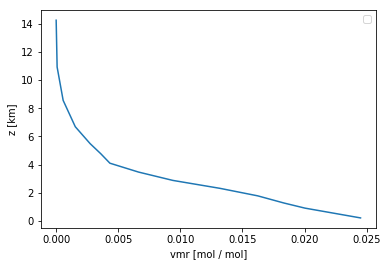

In [5]:
alt = np.asarray(ws.z_field).ravel() * .001 # altitude in km (for plotting)
plt.xlabel("T [K]")
plt.ylabel("z [km]")
plt.plot(np.asarray(ws.vmr_field)[0,:,0,0], alt)
plt.xlabel("$H_2O [mol/mol$]")
plt.ylabel("z [km]")
plt.xlabel("vmr [mol / mol]")
plt.ylabel("z [km]")
plt.legend()

# Sensor definition

In [6]:
ws.ArrayOfIndexCreate("channels")
ws.channels = list(range(21))
ws.ArrayOfIndexCreate("viewing_angles")
ws.viewing_angles = [47] # index of stored viewing angles in metmm file

ws.sensor_pos  = np.array([[850e3]]) # 850km
ws.sensor_time = np.array([0.0])
ws.sensor_los  = np.array([[180.0]]) # nadir viewing

ws.IndexCreate("met_mm_accuracy") 
ws.met_mm_accuracy = 1 # points within each bandwidth to comute abs characteristics

ws.execute_controlfile("instruments/metmm/sensor_descriptions/prepare_metmm.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/sensor_atms.arts")
ws.execute_controlfile("instruments/metmm/sensor_descriptions/apply_metmm.arts")
ws.execute_controlfile("instruments/metmm/common_metmm.arts")

In [7]:
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.abs_xsec_agenda_checkedCalc()
ws.abs_lookupSetup()
ws.abs_lookupCalc()

## Setup perturbed profile

In [13]:
a_priori = np.copy(ws.vmr_field.value[0, :, 0, 0])
perturbed = 1.4 * a_priori

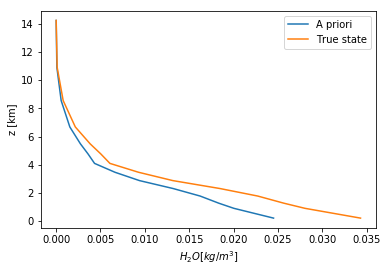

In [14]:
plt.figure()
plt.plot(a_priori, alt, label="A priori")
plt.plot(perturbed, alt, label="True state")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()

# Surface 

In [15]:
ws.surface_scalar_reflectivity = np.array([0.5]) # nominal albedo for surface
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()
ws.sensor_checkedCalc()
ws.jacobianOff()

# Call forward model

Simulate observation setting vmr_field to the perturbed WV profile.

In [16]:
ws.vmr_field.value[0, :, 0, 0] = perturbed
ws.yCalc()
ws.y.value # write out TBs for first ycalc

array([211.82545805, 180.91137948, 229.6254596 , 247.81189001,
       262.77374087, 263.15488675, 250.50202915, 240.06035998,
       230.70341212, 217.80040773, 216.78236113, 216.43070668,
       216.33892405, 216.31905668, 216.31484116, 240.27601164,
       283.88502578, 273.90866088, 267.11796684, 260.69285671,
       253.22142666])

# Set up OEM retrieval

In [28]:
ws.vmr_field.value[0, :, 0, 0] = a_priori
ws.retrievalDefInit()
# Add H2O as retrieval quantity.
ws.retrievalAddAbsSpecies(species="H2O-PWR98",
                          unit="rel",
                          g1=ws.p_grid,
                          g2=ws.lat_grid,
                          g3=ws.lon_grid )
ws.covmat_sxAddBlock(block = np.diag(0.2 ** 2 * np.ones(perturbed.size)))

# Setup observation error covariance matrix.
ws.covmat_seAddBlock(block = 1.0 ** 2 * np.diag(np.ones(ws.y.value.size)))
ws.retrievalDefClose()

# define inversion iteration as function object within python
@arts_agenda
def inversion_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter)
    ws.x2artsAtmAndSurf()
    ws.atmfields_checkedCalc()  # to be safe, rerun checks dealing with atmosph.
    ws.atmgeom_checkedCalc()
    ws.yCalc()  # calculate yf and jacobian matching x
    ws.Copy(ws.yf, ws.y)
    ws.jacobianAdjustAndTransform()
    
ws.Copy(ws.inversion_iterate_agenda, inversion_agenda)

In [29]:
ws.xa = np.ones(perturbed.size) # if supplying user-defined a priori vector
ws.x  = np.array([]) # create empty vector for retrieved state vector?
ws.yf = np.array([]) # create empty vector for simulated TB?
ws.jacobian = np.array([[]])

# Run OEM retrieval

In [30]:
ws.oem_errors = []
ws.OEM(method="gn",
       max_iter=1000,
       display_progress=1,
       max_start_cost=1e5)
print(ws.oem_errors.value)
ws.x2artsAtmAndSurf() # convert from ARTS coords back to user-defined grid

ARTS[94717877104784]: 
ARTS[94717877104784]:                                 MAP Computation                                
ARTS[94717877104784]: Formulation: Standard
ARTS[94717877104784]: Method:      Gauss-Newton
ARTS[94717877104784]: 
ARTS[94717877104784]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.               
ARTS[94717877104784]: --------------------------------------------------------------------------------
ARTS[94717877104784]:     0        25.8936              0        25.8936               
ARTS[94717877104784]:     1        2.27846        1.61793       0.660526        31.2791
ARTS[94717877104784]:     2        2.12218        1.81515       0.307032       0.213188
ARTS[94717877104784]:     3         2.1217        1.81816       0.303547    0.000138554
ARTS[94717877104784]: --------------------------------------------------------------------------------
ARTS[94717877104784]: 
ARTS[94717877104784]: Total number of steps:            3
ARTS[9471787710478

In [31]:
retrieved = np.copy(ws.vmr_field)[0,:,0,0]
ws.x.value

array([1.21021264, 1.38437986, 1.35211056, 1.39418977, 1.48322848,
       1.47327923, 1.3744837 , 1.26930811, 1.20328336, 1.16833211,
       1.17582246, 1.23982605, 1.33618513, 1.31037524, 1.13358723,
       1.01974719])

# Look at results

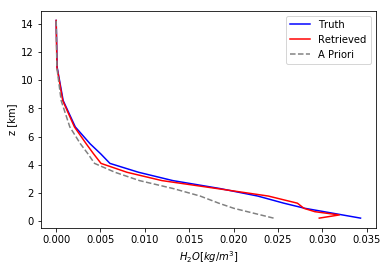

In [35]:
plt.plot(perturbed, alt, label = "Truth", c = "blue")
plt.plot(retrieved, alt, label = "Retrieved", c = "red")
plt.plot(a_priori, alt, label="A Priori", c = "grey", ls = "--")
plt.xlabel("$H_2O [kg / m^3$]")
plt.ylabel("z [km]")
plt.legend()